# Hyperparameters search with Bayesian optimisation

In [3]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
import joblib
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## 1) Data gathering

In [26]:
###############################
N = 5000
dt = 1e-2
pi = np.pi
nb_parts = 100
n_training = 8
n_testing = 5
n_folds = n_training + n_testing
###############################
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.2, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,N,1)
t = np.arange(0,N*dt,dt)
pend = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
###############################
pend.ref = np.empty(shape=[n_folds,N])
for j in range(n_folds):
    x_train = 0
    phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
    f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
    A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
    for i in range(nb_parts):
        x_train = x_train + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    x_train = x_train/max(max(x_train),-min(x_train))*pi
    pend.ref[j,:] = x_train
###############################
Kp, Ki, Kd = 50, 20, 5
pend.U = np.zeros(shape=[n_folds,N-1])
pend.X = np.zeros(shape=[n_folds,2,N])
###############################
for j in range(n_folds):
    pend.X[j,0,0] = pend.ref[j,0]
    for i in range(N-1):
        pend.U[j,i] = PID(pend.X[j,:,:], i, pend.ref[j,i], Kp, Kd, Ki, pend.dt, 20, limit=[-20,20])[0] 
        pend.X[j,:,i+1] = RK4(pend.dynamics, pend.X[j,:,i], pend.U[j,i], pend.dt, type='controller-step-by-step')
        
# Learn on differences ########
pend.dX = np.diff(pend.X, axis=2) # Delta X's
pend.dU = np.diff(pend.U, axis=1) # Delta U's

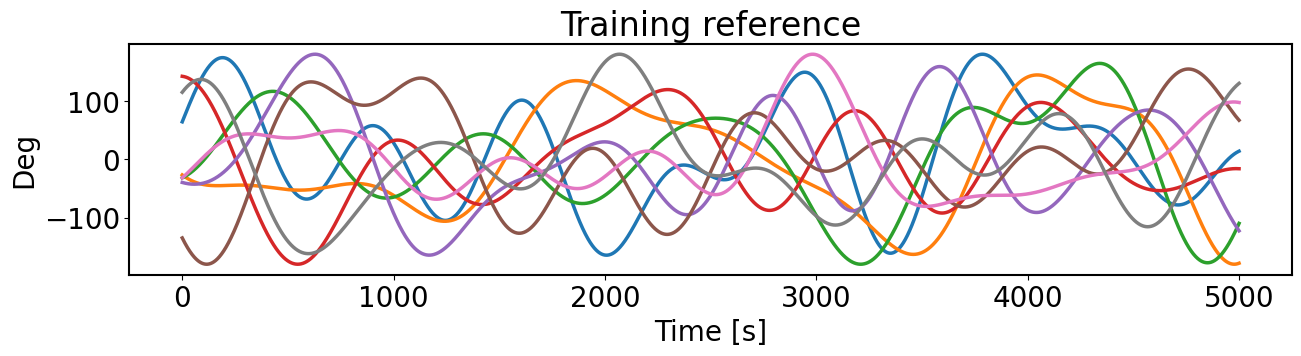

In [14]:
fig, ax = plt.subplots(ncols=1, figsize=(15,3))
ax.set_title('Training reference')
for i in range(n_training):
    ax.plot(pend.T,rad2deg(pend.ref[i,:])), ax.set_xlabel('Time [s]'), ax.set_ylabel('Deg')
plt.savefig('Images/Report/Reference.svg',dpi=800)

## Hyperparameters tuning using *hyperopt*

In [3]:
# Hyperparameters space
traj_ratio = .02
n_low, n_high = 15,60
d_low, d_high = 1, np.int((1-traj_ratio)/n_high*pend.N)
print(pend.N- d_high*n_high)
print(d_high)
#######################################################
space = {
    "dimension": hp.quniform("dimension", 4, 15, 1),
    "nb_trajectories": hp.quniform("nb_trajectories", n_low, n_high, 1),
    "nb_delays": hp.quniform("nb_delays", d_low, d_high, 1),
}
#######################################################
loss_traj = np.empty(shape=[n_training])
loss_U = np.empty(shape=[n_training])
loss_LQR = np.empty(shape=[n_training])

# LQR simulation settings
model = SLFC(pend.X[0,:,:], pend.U[0,:]) # Initialize model paramters

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-15,15] # Limiting contol input size

t_interval = pend.dt

def hyperparameters_tuning(params):
    
    # Model parameters
    n = np.int(params["nb_trajectories"])
    d = np.int(params["nb_delays"])
    s = np.int(params["dimension"])
    
    for fold in range(n_training):
        model = HAVOK(pend.dX[fold,:,:], pend.dU[fold,:], learnOnDiff=True)
        model.HANKEL(n, d)
        model.SVD(s)
        model.LS(s,rcond=0)
#         model.Simulate(pend.X[fold,:,0],U_testing = pend.U[fold,:])
        model.Simulate(pend.X[fold,:,0],U_testing = pend.U[fold,:]) # Learn on differences
        
        # LQR loss ##############################
        Xc, X_lift = np.zeros(shape=[model.nb_S,model.N]), np.zeros(shape=[model.tau,model.N])
        Xc[:,0], X_lift[:,0] = pend.X[fold,:,0], pinv(model.C)@Xc[:,0]
        Uc = np.empty(shape=[model.N-1])
        
#         model.ConstructLQR(x_std=1e6, u_std=2., dt=pend.dt, ref=pend.ref[fold,:])
        model.ConstructLQR(x_std=1e6, u_std=2., dt=pend.dt, ref=pend.ref[fold,:]) # To learn on differences
        model.LQR_simulate(X0=pend.X[fold,:,0])
        
#         # Simulate the closed-loop trajectory for the non-linear dynamics
#         for i in range(model.N-1):

#             Uc[i] = (model.LQR.get_command(X_lift[:,i],i))
# #             Uc[i] = (model.C@model.LQR.get_command(X_lift[:,i],i))[1]
#             if Uc[i] >= u_max[1]: Uc[i] = u_max[1]
#             if Uc[i] <= u_max[0]: Uc[i] = u_max[0]

#             Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
#             X_lift[:,i+1] = pinv(model.C)@Xc[:,i+1]
            
#         loss_traj[fold] = model.RMSE(X_pred=model.X_traj, X_true=pend.X[fold,:,:]) 
#         loss_LQR[fold] = model.RMSE(X_pred=Xc[0,:,np.newaxis].T, X_true=pend.ref[fold,:,np.newaxis].T)
        loss_traj[fold] = model.RMSE(X_pred=model.X_traj, X_true=pend.X[fold,:,:]) 
        loss_LQR[fold] = model.RMSE(X_pred=model.LQR_X[:,0,np.newaxis].T, X_true=pend.ref[fold,:,np.newaxis].T)
        loss_U[fold] = model.RMSE(X_pred=model.LQR_U[:,:,0], X_true=pend.U[fold,:,np.newaxis].T)

#     loss = (loss_LQR.sum() + 3*loss_U.sum())/n_training
    loss = (loss_LQR.sum())/n_training
    
    print('Hyperparameters {}'.format(params), 'Loss {}'.format(loss))
    print('loss : '+str(loss)+' traj : '+str(loss_traj.sum()/n_training)+' LQR : '+str(loss_LQR.sum()/n_training)+' U :'+str(loss_U.sum()/n_training))
    
    return {"loss":loss, "status":STATUS_OK}
#######################################################
# trials = joblib.load('hyperopt_trials.pkl')
trials = Trials()

best = fmin(
    fn = hyperparameters_tuning,
    space = space, 
    algo = tpe.suggest, 
    max_evals = 500, 
    trials = trials
)

joblib.dump(trials, 'hyperopt_trials.pkl')

print('Best hyperparameters {}'.format(best))

140
81
Hyperparameters {'dimension': 15.0, 'nb_delays': 34.0, 'nb_trajectories': 37.0}                                        
Loss 30.748853699151546                                                                                                
loss : 30.748853699151546 traj : 7.244474010507188e+134 LQR : 30.748853699151546 U :155.7267322437936                  
Hyperparameters {'dimension': 7.0, 'nb_delays': 60.0, 'nb_trajectories': 57.0}                                         
Loss 14.56505749282559                                                                                                 
loss : 14.56505749282559 traj : 2.0028151592716728e+59 LQR : 14.56505749282559 U :237.75689162277487                   
Hyperparameters {'dimension': 14.0, 'nb_delays': 67.0, 'nb_trajectories': 43.0}                                        
Loss 17.769888190322213                                                                                                
loss : 17.769888190322213 traj : 

KeyboardInterrupt: 

## Training performance

Loss =  180.6640525490676


(Text(0, 0.5, 'Degrees'), Text(0, 0.5, 'Degrees/sec'))

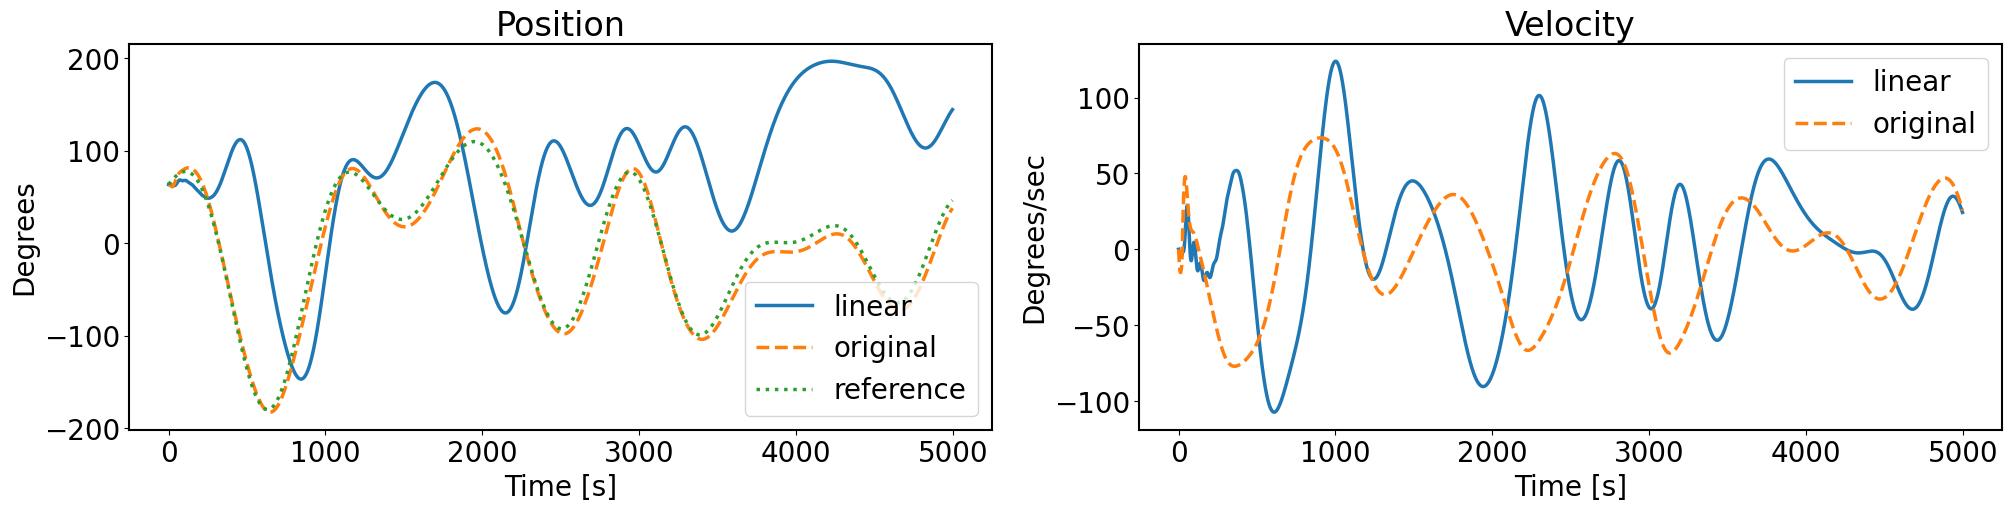

In [27]:
tau = 4 # 4 36 50
# Training
train = 0
# model1 = HAVOK(pend.X[train,:,:], pend.U[train,:])
model1 = HAVOK(pend.dX[train,:,:], pend.dU[train,:], type='learnOnDiff')
horizon = 15
model1.HANKEL(horizon, delay_spacing=1)
model1.SVD(tau)
model1.LS(tau,rcond=0)
model1.Simulate(pend.X[train,:,0],U_testing = pend.U[train,:])
model1.TrajError(pend.X[train,:,:])
print('Loss = ',lg.norm(model1.traj_error,2))
# print(model1.Cu)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(pend.T,rad2deg(model1.X_traj[0,:]),label='linear'), ax[1].plot(pend.T,rad2deg(model1.X_traj[1,:]),label='linear')
ax[0].plot(pend.T,rad2deg(pend.X[train,0,:]),label='original',linestyle='dashed'), ax[1].plot(pend.T,rad2deg(pend.X[train,1,:]),label='original',linestyle='dashed')
ax[0].plot(pend.T,rad2deg(np.array(pend.ref[train,:])),linestyle='dotted',label='reference'), ax[0].legend(), ax[1].legend()
ax[0].set_title('Position'), ax[1].set_title('Velocity')
ax[0].set_xlabel('Time [s]'), ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Degrees'), ax[1].set_ylabel('Degrees/sec')

# plt.savefig('Images/Midterm/Training.png',dpi=800)

## Testing performance

([<matplotlib.lines.Line2D at 0x235565a1c70>],
 <matplotlib.legend.Legend at 0x235565a1fd0>)

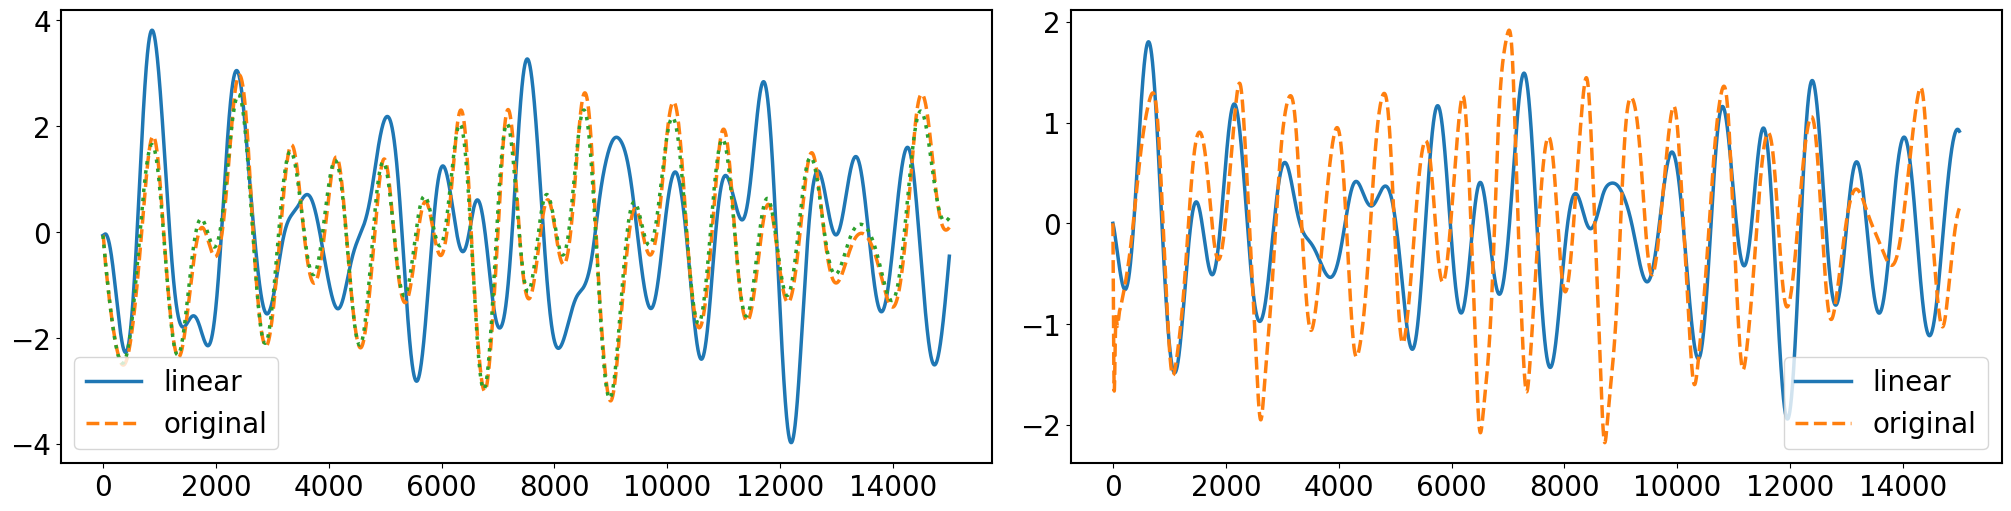

In [134]:
traj = 6
model1.Simulate(pend.X[traj,:,0],U_testing = pend.U[traj,:])
model1.TrajError(pend.X[traj,:,:])
##########################################
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(model1.X_traj[0,:],label='linear'), ax[1].plot(model1.X_traj[1,:],label='linear')
ax[0].plot(pend.X[traj,0,:],label='original',linestyle='dashed'), ax[1].plot(pend.X[traj,1,:],label='original',linestyle='dashed')
ax[0].plot(np.array(pend.ref[traj,:]),linestyle='dotted'), ax[0].legend(), ax[1].legend()

## LQR testing

(1, 4999, 1)


(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(929.7705890844805, 0.5, 'Subspace coordinate $r$'))

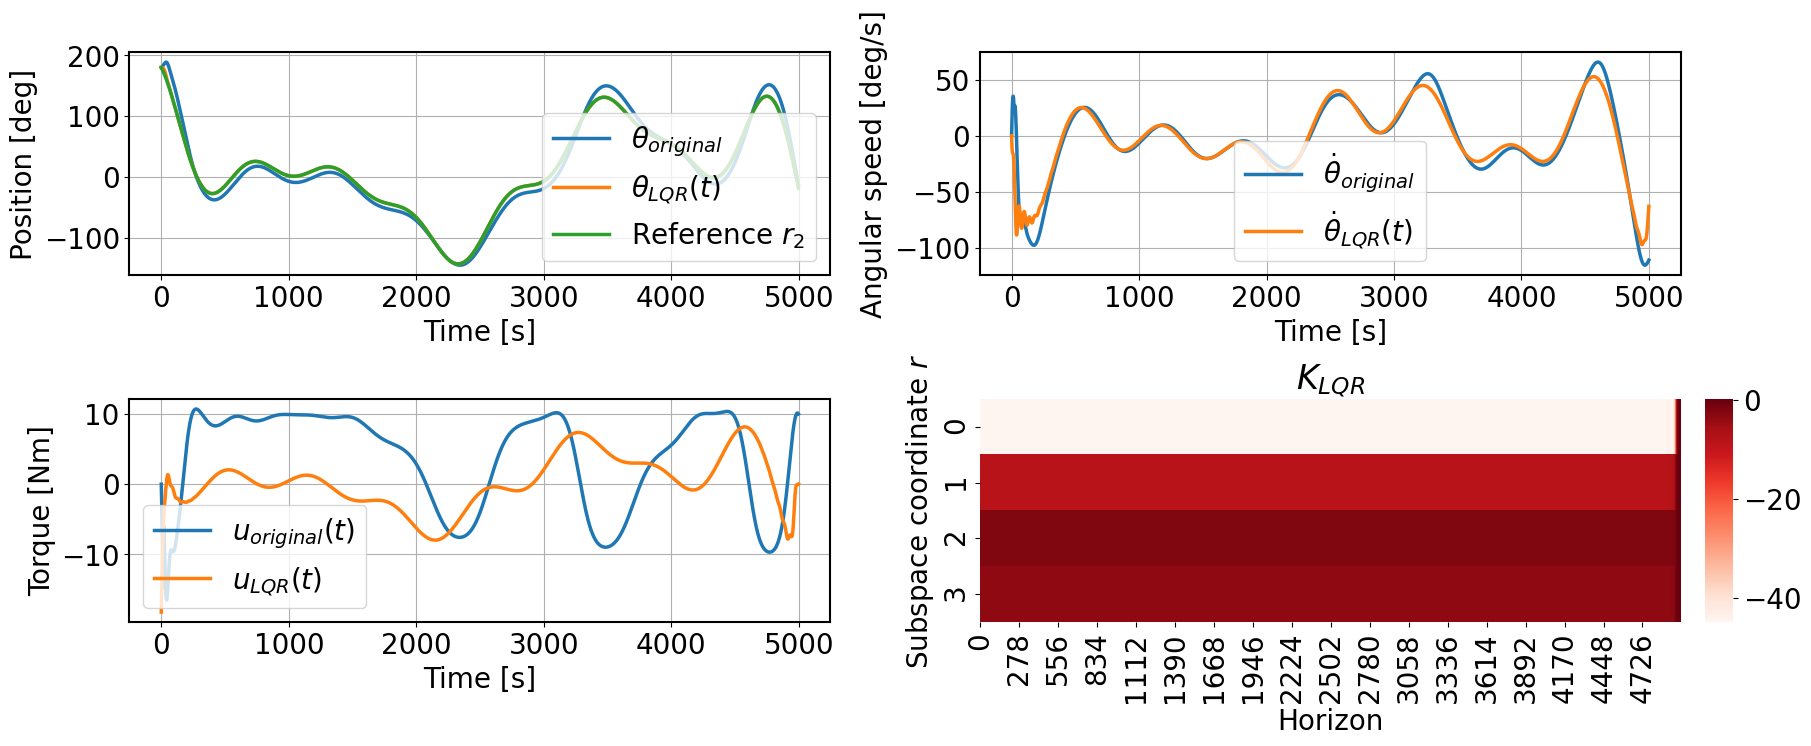

In [28]:
traj = 10
model1.Simulate(np.array([pend.ref[traj,0],0]), U_testing=pend.U[traj,:])
model1.ConstructLQR(x_std=1e6, u_std=2., dt=pend.dt, ref=pend.ref[traj,:])
model1.LQR_simulate(pend.X[traj,:,0])

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.X[traj,0,:]), label=r'$\theta_{original}$')
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref[traj,:])), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[traj,1,:]), label=r'$\dot{\theta}_{original}$')
ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

print(model1.LQR_U[:,:,:].shape)
ax[1,0].plot(pend.T[:model1.N-1], pend.U[traj,:], label='$u_{original}(t)$')
ax[1,0].plot(pend.T[:model1.N-1], (model1.LQR_U[0,:,:].T).T, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

LQR cost :  18605769.018347472
LQR cost :  48533630.4112514
LQR RMSE :  11.114639953134006
PID RMSE :  18.290477745275748
U RMSE :  13.594724509682356


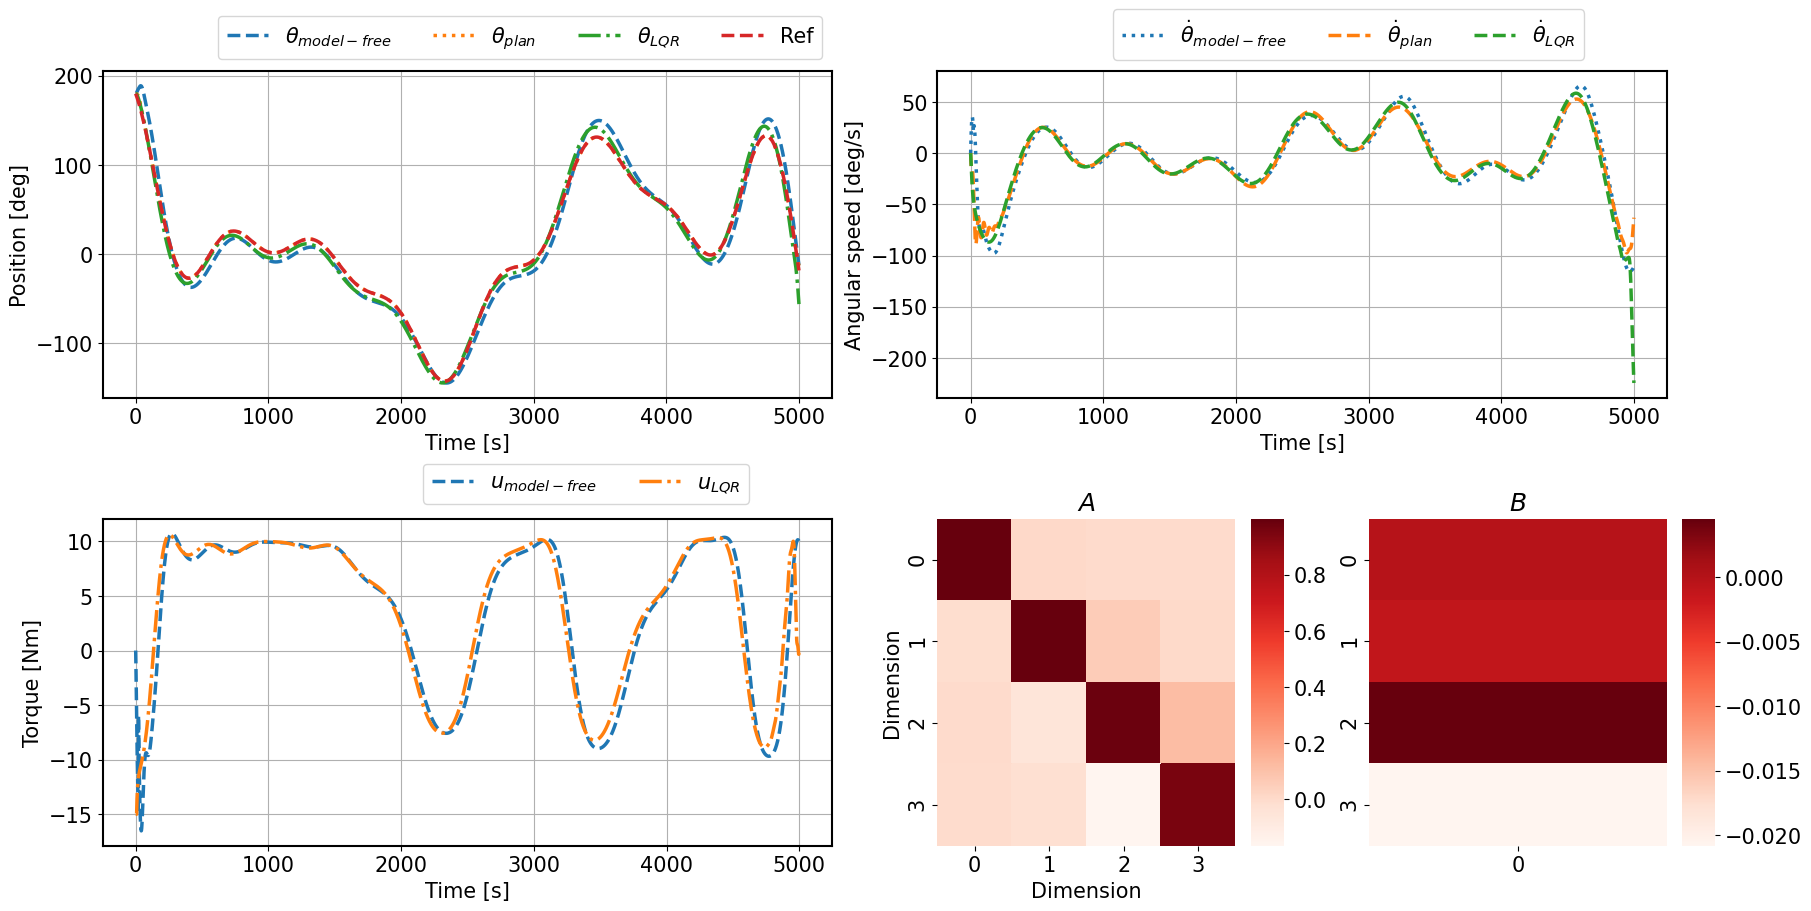

In [29]:
X0 = pend.X[traj,:,0]
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-15,15] # Limiting contol input size

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
#     Uc[i] = (model1.Cu@model1.LQR.get_command(Yc[:,i],i))
    Uc[i] = (model1.LQR.get_command(Yc[:,i],i))[0]
    if Uc[i] >= u_max[1]: Uc[i] = u_max[1]
    if Uc[i] <= u_max[0]: Uc[i] = u_max[0]
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
print('LQR cost : ',model1.LQR_cost(Xc, Uc, pend.ref[traj,:]))
print('LQR cost : ',model1.LQR_cost(pend.X[traj,:,:], pend.U[traj,:], pend.ref[traj,:]))
print('LQR RMSE : ',model1.RMSE(X_pred=Xc[0,:,np.newaxis].T, X_true=pend.ref[traj,:,np.newaxis].T))
print('PID RMSE : ',model1.RMSE(X_pred=pend.X[traj,0,:,np.newaxis].T, X_true=pend.ref[traj,:,np.newaxis].T))
print('U RMSE : ',model.RMSE(X_pred=Uc[:,np.newaxis].T, X_true=pend.U[traj,:,np.newaxis].T))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:6])
ax11_1 = fig.add_subplot(gs[4:8,6:8])

ax00.plot(pend.T, rad2deg(pend.X[traj,0,:]), linestyle='dashed', label=r'$\theta_{model-free}$')
ax00.plot(pend.T, rad2deg(model1.LQR_X[:,0]), linestyle=':', label=r'$\theta_{plan}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), linestyle='dashdot', label=r"$\theta_{LQR}$")
ax00.plot(pend.T, rad2deg(np.array(pend.ref[traj,:])), linestyle='dashed', label='Ref')
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[traj,1,:]), linestyle='dotted', label=r'$\dot{\theta}_{model-free}$')
ax01.plot(pend.T, rad2deg(model1.LQR_X[:,1]), linestyle='dashed', label=r"$\dot{\theta}_{plan}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), linestyle='dashed', label=r"$\dot{\theta}_{LQR}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model1.N-1], pend.U[traj,:], linestyle='dashed', label='$u_{model-free}$')
# ax10.plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], linestyle='dotted', label='$u_{plan}$')
ax10.plot(pend.T[:model1.N-1], Uc, linestyle='dashdot', label='$u_{LQR}$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model1.A,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model1.B,cmap='Reds')

# fig.savefig('Images/Pend_HAVOK_trajectories_sine2.svg',format='svg',dpi=800)
# fig.savefig('Images/Report/LQR_tracking.svg',dpi=800)

## Pendulum swing up

LQR rollout : 
RMSE U1 : 10739643.223689923
RMSE U2 : 10036202.83342549
LQR on true dynamics : 
RMSE U1 : 224118.95143203405
RMSE U2 : 256029.67445175655


(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(915.8268176960559, 0.5, 'Subspace coordinate $r$'))

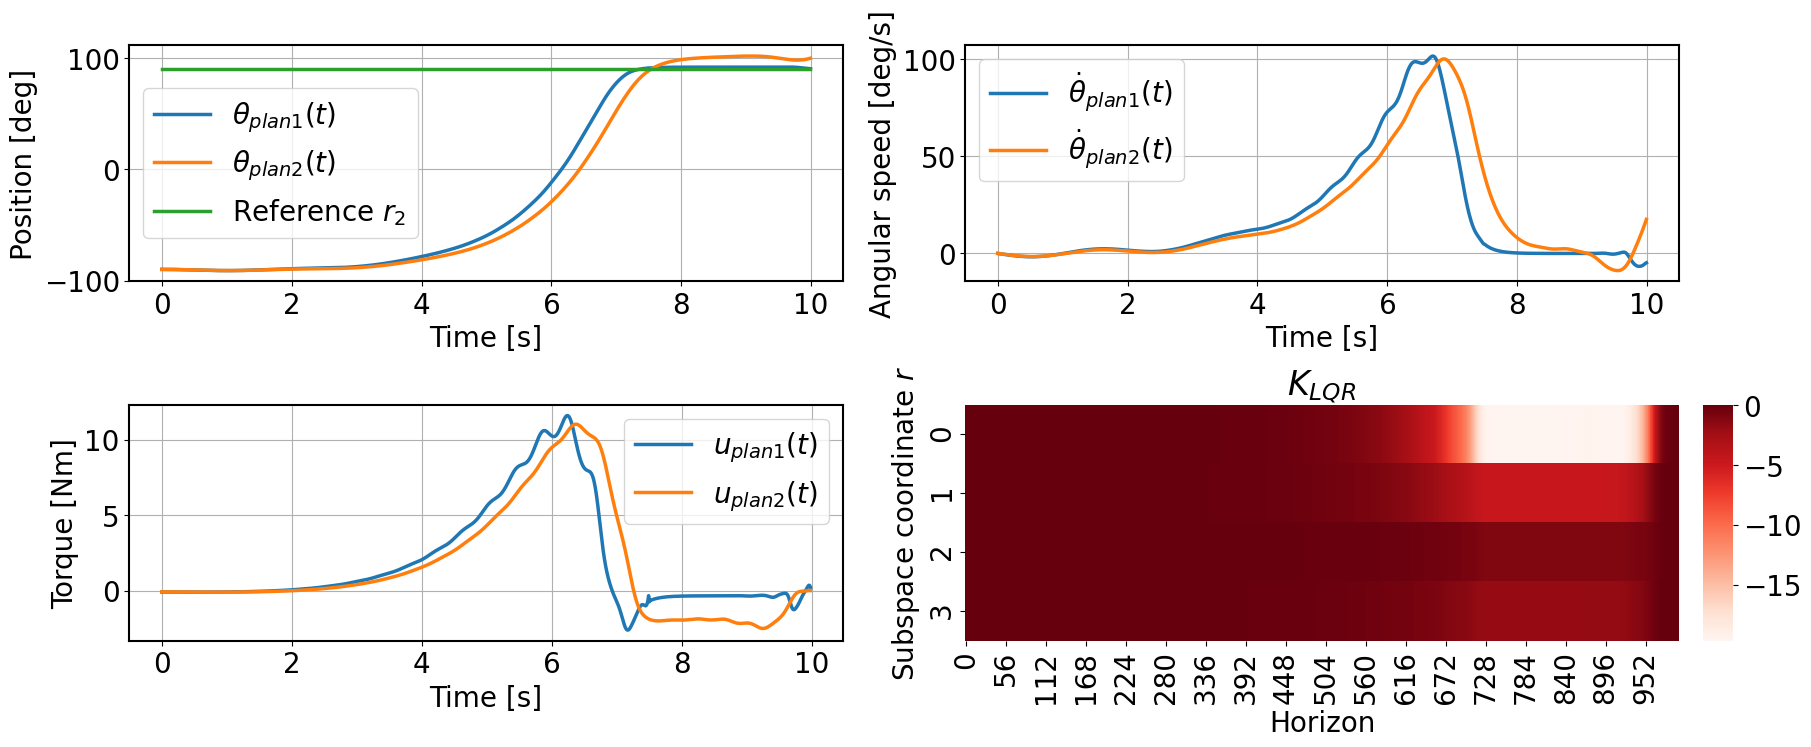

In [37]:
# freq = .05
dt = 1e-2
period = 1/freq/dt

pend3 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(120),0]), dt=dt)
pend = pend3

x_std, x_std1, x_std2 = 1e8, 1e0, 1e8
# x_std_inc = np.linspace(x_std1, x_std2, np.int(4*pend.N/4))
pend.ref = np.zeros([2,pend.N])
# pend.ref[0,:] = sineReference(pend.N, pend.dt, period, 180, -90)
pend.ref[0,:] = deg2rad(90*np.ones(pend.N))
precision1, precision2 = np.zeros(shape=[2,pend.N]), np.zeros(shape=[2,pend.N])
nb = np.int(pend.N/(period/2))

precision1[0,np.int(3*pend.N/4):pend.N] = np.ones(np.int(1*pend.N/4))*x_std
precision2[0,np.int(3*pend.N/4):pend.N] = np.ones(np.int(1*pend.N/4))*x_std

# precision1[0,np.int(0*pend.N/4):pend.N] = x_std_inc
# precision2[0,np.int(0*pend.N/4):pend.N] = x_std_inc

# plt.plot(precision1[0,:]/x_std)
# plt.plot(precision2[0,:]/x_std)
# plt.plot(pend.ref[0,:]/deg2rad(90),linestyle='dashed')

u_std = 2.2
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, precision=precision1)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
RMSE_LQR1 = model1.RMSE(X_pred=model1.LQR_U[:,:,0].T,
                      X_true=np.zeros(shape=[1,pend.N-1]), type='input')

LQR1_X, LQR1_U, LQR1 = model1.LQR_X, model1.LQR_U, model1.LQR

u_std = 4.7
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, precision=precision2)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
RMSE_LQR2 = model1.RMSE(X_pred=model1.LQR_U[:,:,0].T,
                      X_true=np.zeros(shape=[1,pend.N-1]), type='input')

LQR2_X, LQR2_U, LQR2 = model1.LQR_X, model1.LQR_U, model1.LQR

X0 = np.array([deg2rad(-90),0])
Xc, Yc = np.zeros(shape=[2,model1.nb_S,pend.N]), np.zeros(shape=[2,model1.tau,pend.N])
Uc = np.empty(shape=[2,pend.N-1])
t_interval = pend.dt

LQR = np.array([LQR1,LQR2])

# Initial condition
Xc[:,:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-20,20]

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(pend.N-1):
    
    for j in range(2):
        Uc[j,i] = LQR[j].get_command(Yc[j,:,i],i)
        
        if Uc[j,i] >= u_max[1]: Uc[j,i] = u_max[1]
        if Uc[j,i] <= u_max[0]: Uc[j,i] = u_max[0]

        Xc[j,:,i+1]= RK4(f, Xc[j,:,i], Uc[j,i], t_interval, type='controller-step-by-step')
        Yc[j,:,i+1] = pinv(model1.C)@Xc[j,:,i+1]
    
# # Evaluate LQR RMSE's

RMSE_U1 = model1.RMSE(X_pred=Uc[0,:,np.newaxis].T, X_true=np.zeros(shape=[1,pend.N-1]), type='input')
RMSE_U2 = model1.RMSE(X_pred=Uc[1,:,np.newaxis].T, X_true=np.zeros(shape=[1,pend.N-1]), type='input')

print('LQR rollout : ')
print('RMSE U1 : '+str(RMSE_LQR1))
print('RMSE U2 : '+str(RMSE_LQR2))
print('LQR on true dynamics : ')
print('RMSE U1 : '+str(RMSE_U1))
print('RMSE U2 : '+str(RMSE_U2))
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(Xc[0,0,:]), label=r"$\theta_{plan1} (t)$")
ax[0,0].plot(pend.T, rad2deg(Xc[1,0,:]), label=r"$\theta_{plan2} (t)$")
ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[0,1,:]), label=r"$\dot{\theta}_{plan1} (t)$")
ax[0,1].plot(pend.T, rad2deg(Xc[1,1,:]), label=r"$\dot{\theta}_{plan2} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], Uc[0,:], label='$u_{plan1}(t)$')
ax[1,0].plot(pend.T[:pend.N-1], Uc[1,:], label='$u_{plan2}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

In [33]:
pend.ref[:,pend.ref.shape[1]-1]

array([1.5708, 0.    ])